# Overfit news popularity

In the previous notebook, we tried to fit IRM with a linear model. Here, we'll try to overfit the news with an neural network (we'll include the pieces for IRM, but turn it off at first, and turn it on again if it works), just to make sure we can actually model the dataset.

## Imports

In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import grad

## Read data

Part of the reason this dataset seems hard to model is the wide range of the target. We'll take the log to try and make the technical learning problem easier.

In [2]:
df = pd.read_csv('../../data/OnlineNewsPopularity/OnlineNewsPopularity.csv')
df.columns = df.columns.map(str.strip) # remove leading spaces from column names
df['shares'] = df['shares'].apply(np.log)

## Split data into environments

We'll split on the number of days since release, which covers almost two years. We can experiment with how many environments we create.

min timedelta:  8.0
max timedelta:  731.0


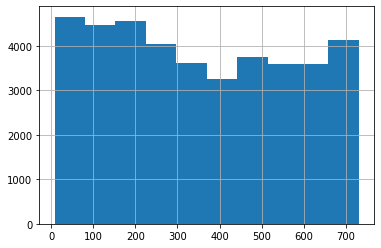

In [3]:
print('min timedelta: ', df.timedelta.min())
print('max timedelta: ', df.timedelta.max())
df.timedelta.hist()

In [4]:
environment_1_df = df[df.timedelta < 180]
environment_2_df = df[(df.timedelta >= 180) & (df.timedelta < 360)]
environment_3_df = df[(df.timedelta >= 360) & (df.timedelta < 540)]
environment_4_df = df[(df.timedelta >= 540)]

Are our environments about equally sized?

In [5]:
[x for x in map(len, [environment_1_df, environment_2_df, environment_3_df, environment_4_df])]

[10866, 9993, 8690, 10095]

Close enough.

## IRM on two environments

We'll first perform IRM on two environments to arrive an invariant representation. We'll then test the performance of the IRM representation vs a non-IRM learned version on the two holdout environments.

Part of the reason the data may be hard to fit is the wide domain of the number of shares.

In [6]:
def df_to_tensors(df):
    features = torch.tensor(
        df.drop(['url','timedelta','shares'],
                axis='columns')
          .to_numpy()
    ).double()
    
    target = torch.tensor(
        df['shares'].to_numpy()
    ).unsqueeze(1).double()
    
    return (features, target)

In [7]:
env_1_tensors = df_to_tensors(environment_1_df)
env_2_tensors = df_to_tensors(environment_2_df)
env_3_tensors = df_to_tensors(environment_3_df)
env_4_tensors = df_to_tensors(environment_4_df)

In [8]:
n_features = env_1_tensors[0].shape[1]

In [9]:
train_environments = [env_1_tensors, env_2_tensors]
holdout_environments = [env_3_tensors, env_4_tensors]

In [10]:
HIDDEN_DIM = 100 # this feels like plenty of capacity for ~10,000 data points per environment

In [11]:
class NN(nn.Module):
    def __init__(self, n_features, hidden_dim):
        super(NN, self).__init__()
        self.layer1 = nn.Linear(n_features, hidden_dim).double()
        self.layer2 = nn.Linear(hidden_dim, hidden_dim).double()
        self.layer3 = nn.Linear(hidden_dim, hidden_dim).double()
        self.layer4 = nn.Linear(hidden_dim, hidden_dim).double()
        self.layer5 = nn.Linear(hidden_dim, 1).double()
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        x = F.relu(self.layer4(x))
        x = self.layer5(x)
        return x

In [12]:
# split into two random mini-batches of size b (random happens in the iteration)
# an unbiased estimate of the squared gradient norm

def compute_penalty(losses, dummy_w):
    g1 = grad(losses[0::2].mean(), dummy_w, create_graph=True)[0]
    g2 = grad(losses[1::2].mean(), dummy_w, create_graph=True)[0]
    return (g1 * g2).sum()

In [13]:
net = NN(n_features, HIDDEN_DIM)

In [14]:
dummy_w = nn.Parameter(torch.Tensor([1.0]))
opt = optim.Adam(net.parameters(), lr=1e-3)
mse = nn.MSELoss(reduction="none")

We could probably speed up training by scaling (min-max or z-score) the input features.

In [15]:
# This IRM penalty weight. Should be searched over.
# May need annealing (holding low to start), as in author's MNIST implementation.
# We'll turn off the IRM penalty to begin with, and see if we can overfit the dataset
# (i.e. discover if this is a learnable problem)
LAMBDA = 1e0

In [16]:
for iteration in range(2000):
    error = 0
    penalty = 0
    loss = 0
    for x_e, y_e in train_environments:
        # here we permute data so that we get random minibatches when we compute the penalty.
        # this gives us an unbiased estimate for the squared gradient norm.
        p = torch.randperm(len(x_e))
        error_e = mse(net(x_e) * dummy_w, y_e[p])
        penalty += compute_penalty(error_e, dummy_w)
        error += error_e.mean()
    
    loss = error
    # To reactivate the IRM, use this instead
    # loss = (error + LAMBDA * penalty) / LAMBDA # rescaling to avoid exploding gradients
        
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    if iteration % 10 == 0:
        print('iteration: {}, loss: {}'.format(iteration, loss.item()))

iteration: 0, loss: 68271.20762085661
iteration: 10, loss: 1024983.901562671
iteration: 20, loss: 155259.04266475065
iteration: 30, loss: 5487.282879941637
iteration: 40, loss: 14293.898795726618
iteration: 50, loss: 10949.871069103277
iteration: 60, loss: 2466.5478272877895
iteration: 70, loss: 748.9011142960085
iteration: 80, loss: 758.5602830837008
iteration: 90, loss: 409.4144654159728
iteration: 100, loss: 381.3093534190512
iteration: 110, loss: 305.4051928183599
iteration: 120, loss: 265.92813371816055
iteration: 130, loss: 239.0415656367238
iteration: 140, loss: 212.87855075805408
iteration: 150, loss: 189.48683957621375
iteration: 160, loss: 168.94400069299775
iteration: 170, loss: 150.10972294447816
iteration: 180, loss: 133.9317657056451
iteration: 190, loss: 119.92497615653926
iteration: 200, loss: 106.8158086826165
iteration: 210, loss: 96.18002777588072
iteration: 220, loss: 90.12272874929229
iteration: 230, loss: 84.62623866539123
iteration: 240, loss: 79.43803912801802
i

After playing with the capacity of the network (both number of hidden layers and width), and running the above cell multiple times (which picks up from the last iteration and continues), I managed to get the loss (squared error) on the _log_ of the number of shares down to ~ 7.

Let's check if our predictor is any good. We'll plot the predictions against ground truth for one of the training environments. If the learner is working, we should see a straight line. This doesn't mean our predictor will generalize - we're hoping to overfit for the time being.

In [19]:
pred_env_1 = net(env_1_tensors[0]).squeeze()

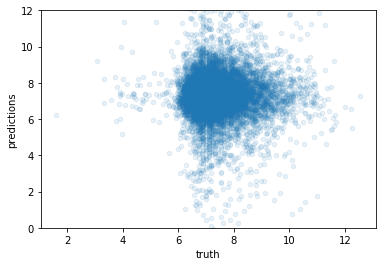

In [21]:
(pd.DataFrame(
    {'predictions': pred_env_1.tolist(),
     'truth': env_1_tensors[1].squeeze().tolist()})
 .plot(x='truth', y='predictions',
       kind='scatter',
       ylim=[0,12],
       alpha=0.1))

# Result

The fit is pretty poor. Let's look for another dataset with a more learnable objective (turns out, we still can't predict how popular something will be /shrug).